<a href="https://colab.research.google.com/github/dernameistegal/airbnb_price/blob/main/feature_extraction_pictures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
#@title remove repos from disc
%cd /content
!rm -r airbnb_price

/content


In [4]:
#@title Clone repo
!git clone https://github.com/dernameistegal/airbnb_price.git

Cloning into 'airbnb_price'...
remote: Enumerating objects: 44, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 44 (delta 14), reused 23 (delta 2), pack-reused 0
Unpacking objects: 100% (44/44), done.


In [1]:
#@title add paths to library search path
import sys 

sys.path.append("/content/airbnb_price/custom_functions")
sys.path.append("/content/airbnb_price/feature_extraction")

In [2]:
#@title Imports and drive
import os
import torch
import torchvision

# own modules
import general_utils as gu
import feature_extraction_utils as fu



from google.colab import drive

#@title Mount drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [3]:
#@title define device

# device
device = gu.get_device()
num_cpus = os.cpu_count()
print(num_cpus, 'CPUs available')

cuda available: True ; cudnn available: True ; num devices: 1
Using device Tesla T4
2 CPUs available


In [ ]:
# calculate channelwise moments of pictures
hostpics_dir = "/content/drive/MyDrive/Colab/rbnb/data/hostpics"

means, stds = fu.calculate_channelwise_moments(hostpics_dir)

In [15]:
import numpy as np
import matplotlib.pyplot as plt
data_paths = os.listdir(hostpics_dir)
x = np.load(hostpics_dir + "/" + data_paths[34])

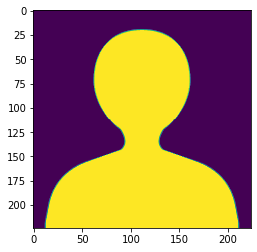

In [16]:
plt.imshow(x)

In [4]:
#@title make dataset


# initialize dataset and dataloader
dataset = fu.Dataset(hostpics_dir, means, stds, 10)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False)

# get pretrained model
vgg = torchvision.models.vgg19(pretrained=True)
feature_extractor = vgg.features[0:31]

# compute features for later training
x = fu.compute_train_features(device, dataloader, feature_extractor)



























RuntimeError: ignored

In [ ]:
model_name = "pointnet2_2" # model to be trained
model = importlib.import_module(model_name)
destination_path = "/content/Pointnet_Pointnet2_pytorch/log/part_seg/"
destination_path = destination_path + model_name

In [ ]:
# Use pretrained model? If yes run this chunk
source_path = "/content/drive/MyDrive/Colab/tree_learning/trained_models/PartSeg1"  # pretrained model to be used (check for compatibility with model to be trained)
source_path = source_path + "/."
!rm -r $destination_path
!mkdir $destination_path
!cp -a $source_path $destination_path

In [ ]:
# generate train and val split to be used in dataloaders
gu.gen_split(percentages=[0.7, 0.3])

In [ ]:
# train model
!python train_partseg.py --model $model_name --log_dir $model_name --npoint 8192 --epoch 30 --step_size 30 --batch_size 8 --weight 1

In [ ]:
# Save trained model? If yes run this chunk
source_path = "/content/Pointnet_Pointnet2_pytorch/log/part_seg/"
source_path = source_path + model_name
source_path = source_path + "/."
destination_path = "/content/drive/MyDrive/Colab/tree_learning/trained_models/test/test/" # destination path to save trained model and corresponding files

!mkdir -p $destination_path
!cp -a $source_path $destination_path

In [ ]:
#@title plot performance
# plot loss and accuracy against epochs
    
loss_path = "/content/Pointnet_Pointnet2_pytorch/log/part_seg/" + model_name + "/performance/loss.npy"
pu.plot("Loss", "Loss", loss_path, yscale='linear')

accs_path = "/content/Pointnet_Pointnet2_pytorch/log/part_seg/" + model_name + "/performance/accs.npy"
pu.plot("Accuracy", "Accuracy", accs_path, yscale='linear')

w_accs_path = "/content/Pointnet_Pointnet2_pytorch/log/part_seg/" + model_name + "/performance/w_accs.npy"
pu.plot("weighted Accuracy", "weighted Accuracy", w_accs_path, yscale='linear')

w_accs_path = "/content/Pointnet_Pointnet2_pytorch/log/part_seg/" + model_name + "/performance/tree_accs.npy"
pu.plot("tree Accuracy", "tree Accuracy", w_accs_path, yscale='linear')

w_accs_path = "/content/Pointnet_Pointnet2_pytorch/log/part_seg/" + model_name + "/performance/no_tree_accs.npy"
pu.plot("no tree Accuracy", "no tree Accuracy", w_accs_path, yscale='linear')

mious_path = w_accs_path = "/content/Pointnet_Pointnet2_pytorch/log/part_seg/" + model_name + "/performance/mious.npy"
pu.plot("miou", "miou", mious_path, yscale='linear')

#Analysis

In [ ]:
#@title definition of visual analysis function
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt


def explore2(points, prediction, label, mode="pointcloud", colormode="binary"):

    # explore results with pointcloud
    if mode == "pointcloud":
        if colormode == "binary":
            prediction[np.logical_and(label == 1, prediction == 1)] = 4  # true positive
            prediction[np.logical_and(label == 1, prediction == 0)] = 2  # false negative
            prediction[np.logical_and(label == 0, prediction == 1)] = 3  # false positive
            prediction[np.logical_and(label == 0, prediction == 0)] = 1  # true negative
        
        df = pd.DataFrame(data=np.column_stack((points, label, prediction)), columns=["x", "y", "z", "label", "prediction"])
        # create vector of sizes (two sizes for tree and non-tree points)
        size = df.iloc[:, -2] * 0.02 + 1

        fig = px.scatter_3d(df, x='x', y='y', z='z',
                            color='prediction',
                            symbol='label', size=size, opacity=0, size_max=5)

        # tight layout
        fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

        fig.show()

    # explore results with histogram
    if mode == "histogram":
        tp = sum(np.logical_and(label == 1, prediction >= 0.5))
        fn = sum(np.logical_and(label == 1, prediction <= 0.5))
        fp = sum(np.logical_and(label == 0, prediction >= 0.5))
        tn = sum(np.logical_and(label == 0, prediction <= 0.5))
        print(f"{tp / len(label)*100:.2f} are true positive")  # true positive
        print(f"{fn / len(label)*100:.2f} are false negative")  # false negative
        print(f"{fp / len(label)*100:.2f} are false positive")  # false positive
        print(f"{tn / len(label)*100:.2f} are true negative")  # true negative
        iou_tree = tp / (tp + fp + fn)
        iou_not_tree = tn / (tn + fn + fp)
        acc_tree, acc_not_tree = tp / (tp + fn), tn / (tn + fp)
        w_acc = (acc_tree + acc_not_tree) / 2
        print(f"the iou_tree is {iou_tree:.4f} the iou_not_tree is {iou_not_tree:.4f}")
        print(f"the miou is {(iou_tree + iou_not_tree) / 2:.4f}")
        print(f"the acc_tree is {acc_tree:.4f} the acc_not_tree is {acc_not_tree:.4f}")
        print(f"the weighted accuracy is {w_acc:.4f}")
        
        fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
        axs[0].hist(prediction)
        axs[1].hist(label)
        fig.show()

In [ ]:
treenumber = 15
npoints = 2048
split_path = "/content/Pointnet_Pointnet2_pytorch/data/" + "valsplit.npy"
# um einen bestimmten Baum zu wählen, die folgende Zeile ausführen
#gu.gen_split(paths = [split_path], shuffle=False, percentages=[1])

In [ ]:
#@title generate predictions for chosen tree from trained model (saved in result)

# load learned model
def inplace_relu(m):
    classname = m.__class__.__name__
    if classname.find('ReLU') != -1:
        m.inplace=True

classifier = model.get_model(2, normal_channel=False).to(device)
classifier.apply(inplace_relu)

model_path = "/content/Pointnet_Pointnet2_pytorch/log/part_seg/" + model_name + "/checkpoints/best_model.pth"
checkpoint = torch.load(model_path)
classifier.load_state_dict(checkpoint['model_state_dict'])

# instantiate dataset (choose from trainsplit, valsplit or nosplit)
root = "/content/Pointnet_Pointnet2_pytorch/data/"


testtransform = t.Compose([t.Normalize()])
TRAIN_DATASET = dset.PartNormalDataset(root=root, 
                                  npoints=npoints,
                                  transform=testtransform,
                                  splitpath=split_path, 
                                  normal_channel=False, mode="eval")

# predict targets for arbitrary tree number
points, label, target, _, upoints = TRAIN_DATASET[treenumber]
points, label, target = torch.tensor(points), torch.tensor(label), torch.tensor(target)
points, target = torch.unsqueeze(points, 0), torch.unsqueeze(target, 0)
points, label, target = points.float().to(device), label.long().to(device), target.long().to(device)
points = points.transpose(2, 1)


def to_categorical(y, num_classes):
    """ 1-hot encodes a tensor """
    new_y = torch.eye(num_classes)[y.cpu().data.numpy(),]
    if (y.is_cuda):
        return new_y.cuda()
    return new_y


with torch.no_grad():
    classifier.eval()
    result = classifier(points, to_categorical(label, 1))[0]


preds = torch.argmax(result[0], axis=1)
points = points[0].T
target = target[0]
points = points[:, :3]
points = points.detach().cpu().numpy()
preds = preds.detach().cpu().numpy()
target = target.detach().cpu().numpy()
m = torch.nn.Softmax()
pred_probabilities = m(result[0])[:,1].detach().cpu().numpy()


In [ ]:
#@title Numerical Analysis for the chosen tree
correct = np.sum(preds == target)
print("Accuracy", correct / (npoints))
# confusion values in numbers and histograms of predicted probabilities and true labels
explore2(upoints, pred_probabilities, target, mode="histogram")

In [ ]:
# plot binary predictions (yellow = true positive, red = false positive, blue = true negative, purple = false negative)
explore2(upoints, preds, target, mode="pointcloud", colormode="binary")

In [ ]:
# non-binary predictions
explore2(upoints, pred_probabilities, np.array(target), mode="pointcloud")